## XGBOOST With BayesSearchCV

### Author - Yogendra Shinde

### Step # 1 : Import required packages

In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
confidence_interval = 95
random_seed = 2023
from helpers import PlotROCCurve

In [2]:
pd.set_option('display.max_columns', 110) 
pd.set_option('display.max_rows', 20) 

### Step # 2 : Read input file

In [3]:
df_train = pd.read_csv(r'E:\SMU_Project_Healthcare\ISSS623_Healthcare_Analytics\Modeling\INPUT_DATA_New\train_drop_v3.csv')
df_test= pd.read_csv(r'E:\SMU_Project_Healthcare\ISSS623_Healthcare_Analytics\Modeling\INPUT_DATA_New\test_drop_v3.csv')

In [4]:
df_train.shape

(273032, 109)

In [5]:
df_test.shape

(68258, 109)

In [6]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 273032 , testing size = 68258


In [7]:
df_train.shape

(273032, 109)

In [8]:
df_train.head()

,intime_ed,outtime_ed,gender,age,outcome_hospitalization,outcome_inhospital_mortality,ed_death,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,insurance_Medicaid,insurance_Medicare,insurance_Other,age_group_Young Adults,age_group_Middle-Aged Adults,age_group_Older Adults,age_group_Elderly,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,9/7/2179 12:19,9/7/2179 12:24,1,52,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.08,36.666667,78.0,18,99.0,123,87,6.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,56.0,16,98.0,105,66,2.0,0,0,0,0,0,0,1,0,0,99.000000,1,0,2,0,0,1
1,3/17/2138 10:35,3/17/2138 10:41,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.10,37.055556,65.0,18,100.0,149,60,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.722222,58.0,16,98.0,143,61,0.0,0,19,0,0,0,0,0,1,0,89.666667,8,4,7,0,0,1
2,10/23/2136 14:50,10/23/2136 14:59,1,30,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,0.15,37.000000,82.0,20,100.0,160,85,7.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36.888889,66.0,18,98.0,127,83,0.0,1,1,0,0,0,1,0,0,0,110.000000,1,0,2,0,0,1
3,8/1/2188 2:06,8/1/2188 9:57,1,39,1,0,0,0,0,0,0,3,1,0,0,1,0,0,0,7.85,36.111111,78.0,14,95.0,127,77,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,36.333333,76.0,18,98.0,107,54,0.0,1,2,0,0,1,0,1,0,0,93.666667,1,0,0,1,0,0
4,11/12/2143 10:30,11/12/2143 20:41,1,59,1,0,0,0,0,0,2,3,0,0,4,4,0,0,0,10.19,36.888889,63.0,18,99.0,230,87,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,36.833333,60.0,16,97.0,164,65,0.0,5,13,0,0,1,0,1,0,0,134.666667,6,4,8,3,3,3


In [9]:
# Understand balance of classes in the given dataframe.
pd.value_counts(df_train['outcome_critical'])

0    261423
1     11609
Name: outcome_critical, dtype: int64

## Step 3. Variable Selection

In [10]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

### 3.1 Create train and test data and label encode gender

In [11]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [12]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [13]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [14]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = -0.04078470775468046 : 1


In [15]:
# Containers for all results
result_list = []

In [16]:
pd.set_option('display.max_columns', 110) 
pd.set_option('display.max_rows', 20) 

In [17]:
X_train.head()

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,52,1,0,0,1,0,0,0,0,0,0,36.666667,78.0,18,99.0,123,87,6.0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,69,0,0,0,0,0,0,0,0,0,0,37.055556,65.0,18,100.0,149,60,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2,30,1,0,0,3,0,0,2,0,0,0,37.000000,82.0,20,100.0,160,85,7.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,39,1,0,0,3,0,0,1,0,0,0,36.111111,78.0,14,95.0,127,77,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1
4,59,1,0,2,3,0,4,4,0,0,0,36.888889,63.0,18,99.0,230,87,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0


### Step #4 : Scaling Train and Test Data

In [18]:
from sklearn.preprocessing import StandardScaler
def scale_train_data(X_train):
    # List of columns to scale
    tot_cols = set(X_train.columns)
    columns_to_scale = ["age", "gender", "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d",
                    "n_hosp_90d", "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
                    "triage_temperature", "triage_heartrate", "triage_resprate", 
                    "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity"]  
    set_columns_to_scale = set(columns_to_scale)
# Create a StandardScaler instance
    std_scaler = StandardScaler()
# Fit and transform the chosen columns
    scaled_data = std_scaler.fit_transform(X_train[columns_to_scale])
# Create a new DataFrame with the scaled data and original index
    X_train_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale, index=X_train.index)
# Create a dataframe of remaining columns and the join it with X_train_scaled
# difference = set1.difference(set2)
    rem_Cols = list(tot_cols.difference(set_columns_to_scale))
    df_rem_cols = X_train[rem_Cols].copy(deep=True)
    X_train_scaled_final = pd.concat([X_train_scaled, df_rem_cols], axis=1)
    return X_train_scaled_final

In [19]:
# Now concatenate X_train_scaled and df_rem_cols to create X_train_scaled_final

In [20]:
X_train_scaled_final1 = scale_train_data(X_train)

In [21]:
X_train_scaled_final1.head()

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,cci_Rheumatic,cci_Pulmonary,chiefcom_chest_pain,cci_CHF,chiefcom_abdominal_pain,eci_PHTN,eci_Alcohol,eci_Psychoses,eci_Coagulopathy,eci_Drugs,cci_Paralysis,cci_Dementia,chiefcom_headache,eci_NeuroOther,cci_PVD,cci_Renal,cci_Liver2,cci_DM1,chiefcom_syncope,eci_FluidsLytes,eci_Valvular,cci_PUD,cci_DM2,cci_MI,eci_HTN1,chiefcom_cough,chiefcom_fever_chills,eci_Arrhythmia,eci_Anemia,cci_Stroke,chiefcom_dizziness,eci_Hypothyroid,cci_Cancer1,eci_Lymphoma,chiefcom_shortness_of_breath,eci_HTN2,eci_Obesity,eci_Depression,chiefcom_back_pain,cci_HIV,chiefcom_nausea_vomiting,eci_BloodLoss,eci_WeightLoss,cci_Liver1,cci_Cancer2
0,-0.027682,1.099024,-0.308501,-0.336180,-0.099839,-0.314707,-0.362917,-0.373358,-0.107659,-0.155808,-0.200659,-0.078777,-0.404060,0.204359,0.252946,-0.554563,0.627382,0.495731,2.029976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.805815,-0.909898,-0.308501,-0.336180,-0.341491,-0.314707,-0.362917,-0.373358,-0.107659,-0.155808,-0.200659,0.636105,-1.148560,0.204359,0.685934,0.616156,-1.194756,-1.103973,-1.012770,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-1.106324,1.099024,-0.308501,-0.336180,0.383467,-0.314707,-0.362917,0.415129,-0.107659,-0.155808,-0.200659,0.533979,-0.174983,1.060306,0.685934,1.111460,0.492409,0.762349,0.508603,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.665061,1.099024,-0.308501,-0.336180,0.383467,-0.314707,-0.362917,0.020885,-0.107659,-0.155808,-0.200659,-1.100037,-0.404060,-1.507534,-1.479004,-0.374453,-0.047484,-1.103973,2.029976,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.315523,1.099024,-0.308501,0.946232,0.383467,-0.314707,3.734254,1.203616,-0.107659,-0.155808,-0.200659,0.329727,-1.263099,0.204359,0.252946,4.263396,0.627382,-1.103973,-1.012770,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0


In [22]:
X_train_scaled_final1.shape

(273032, 64)

In [23]:
x= X_test.columns
print(len(x))

64


In [24]:
from sklearn.preprocessing import StandardScaler

def scale_test_data(X_test):
    # List of columns to scale
    tot_cols = set(X_test.columns)
    columns_to_scale = ["age", "gender", "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d",
                       "n_hosp_90d", "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
                       "triage_temperature", "triage_heartrate", "triage_resprate", 
                       "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity"]  
    set_columns_to_scale = set(columns_to_scale)
    
#     # Create a StandardScaler instance
    std_scaler = StandardScaler()
    
    # Transform the chosen columns
    scaled_data = std_scaler.fit_transform(X_test[columns_to_scale])
#    scaled_data = std_scaler.transform(X_test[columns_to_scale])
    
    # Create a new DataFrame with the scaled data and original index
    X_test_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale, index=X_test.index)
    
    # Create a dataframe of remaining columns and then join it with X_train_scaled
    rem_Cols = list(tot_cols.difference(set_columns_to_scale))
    df_rem_cols = X_test[rem_Cols].copy(deep=True)
    X_test_scaled_final = pd.concat([X_test_scaled, df_rem_cols], axis=1)
    
    return X_test_scaled_final


In [25]:
X_test_scaled_final1 = scale_test_data(X_test)

In [26]:
X_test_scaled_final1

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,cci_Rheumatic,cci_Pulmonary,chiefcom_chest_pain,cci_CHF,chiefcom_abdominal_pain,eci_PHTN,eci_Alcohol,eci_Psychoses,eci_Coagulopathy,eci_Drugs,cci_Paralysis,cci_Dementia,chiefcom_headache,eci_NeuroOther,cci_PVD,cci_Renal,cci_Liver2,cci_DM1,chiefcom_syncope,eci_FluidsLytes,eci_Valvular,cci_PUD,cci_DM2,cci_MI,eci_HTN1,chiefcom_cough,chiefcom_fever_chills,eci_Arrhythmia,eci_Anemia,cci_Stroke,chiefcom_dizziness,eci_Hypothyroid,cci_Cancer1,eci_Lymphoma,chiefcom_shortness_of_breath,eci_HTN2,eci_Obesity,eci_Depression,chiefcom_back_pain,cci_HIV,chiefcom_nausea_vomiting,eci_BloodLoss,eci_WeightLoss,cci_Liver1,cci_Cancer2
0,-1.403931,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-0.491346,-0.230937,0.201272,0.251897,-0.691948,-0.447720,0.229926,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.220542,-0.912484,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-1.000706,1.950454,-0.644118,0.251897,-1.594453,-1.517194,0.763062,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.401977,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,3.074174,0.113493,1.046662,-1.496608,-0.105320,-0.982457,-0.303209,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-1.502384,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-0.898834,0.400518,0.201272,-0.185229,-0.150445,0.087017,0.496494,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-1.650063,1.095910,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,-0.695090,-0.230937,0.201272,0.689023,1.067936,1.357017,-1.102913,0.506729,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68253,-0.763987,1.095910,-0.308916,0.301281,0.383562,-0.310464,0.662366,1.219357,-0.10453,-0.154257,2.579568,0.018014,-1.206823,-0.644118,0.689023,-0.782199,-0.848773,0.496494,-1.015176,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
68254,-0.370176,-0.912484,-0.308916,-0.340849,0.139803,-0.310464,-0.366109,0.819295,-0.10453,-0.154257,2.579568,-1.408194,1.433809,-0.644118,0.251897,-0.376072,0.755438,1.562766,0.506729,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
68255,0.122089,-0.912484,-0.308916,-0.340849,-0.347715,-0.310464,0.662366,0.419233,-0.10453,-0.154257,-0.199105,-1.408194,-0.345748,-0.644118,-0.185229,1.067936,0.153859,1.562766,-1.015176,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
68256,0.466674,-0.912484,-0.308916,-0.340849,-0.347715,-0.310464,-0.366109,-0.380891,-0.10453,-0.154257,-0.199105,0.323630,0.687543,-0.644118,-0.185229,0.165431,-0.046667,1.296198,0.506729,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Step-5 : XGBoost with BayesSearchCV Hyper-parameter Tuning.

In [35]:
# Import packages
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

# Define the pipeline
# estimators = [('encoder', TargetEncoder()),
#               ('clf', XGBClassifier(random_state=20))]
# Define the pipeline
estimators = [('clf', XGBClassifier(random_state=20))]

# Encoding like this is a standard pre-processing process.
pipe = Pipeline(steps=estimators)

## Set up hyperparameters in Hyperparameter Search Space
hyperparam_searchspace = {
    'clf__clf__max_depth': Integer(2, 8),
    'clf__clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__clf__subsample': Real(0.5, 1.0),
    'clf__clf__colsample_bytree': Real(0.5, 1.0),
    'clf__clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__clf__colsample_bynode': Real(0.5, 1.0),
    'clf__clf__reg_alpha': Real(0.0, 10.0),
    'clf__clf__reg_lambda': Real(0, 10.0),
    'clf__clf__gamma': Real(0.0, 10.0)
}

# Create the BayesSearchCV object
opt = BayesSearchCV(pipe, hyperparam_searchspace, cv=3, n_iter=10, scoring='roc_auc', random_state=20)

# Fit the optimization
start = time.time()
opt.fit(X_train_scaled_final1, y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(opt, model_dump)
print('Training time:', runtime, 'seconds')

[17:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__reg_alpha", "clf__reg_lambda", "clf__subsample" } are not used.

[17:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__reg_alpha", "clf__reg_lambda", "clf__subsample" } are not used.

[17:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma"

[17:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__reg_alpha", "clf__reg_lambda", "clf__subsample" } are not used.

[17:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__reg_alpha", "clf__reg_lambda", "clf__subsample" } are not used.

[17:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma"

AUC: 0.8583118077812368
AUPRC: 0.2554833637306046
Sensitivity: 0.801762114537445
Specificity: 0.7641906686878895
Score thresold: 0.039246246
2.5 97.5


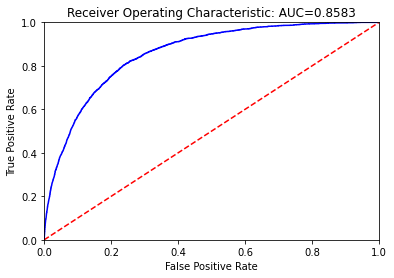

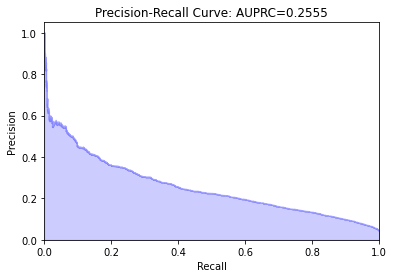

In [36]:
#---
probs = opt.predict_proba(X_test_scaled_final1)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)
results = ["XGBOOST"]
results.extend(result)
results.append(runtime)
result_list.append(results)
#---

In [37]:
opt.best_score_
opt.score(X_test_scaled_final1, y_test)
#---

0.8583118077812368

In [29]:
opt.predict(X_test_scaled_final1)

Proba


array([0, 0, 0, ..., 0, 0, 0])

AUC: 0.8583118077812368
AUPRC: 0.2554833637306046
Sensitivity: 0.801762114537445
Specificity: 0.7641906686878895
Score thresold: 0.039246246
2.5 97.5


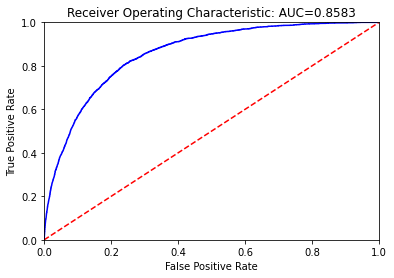

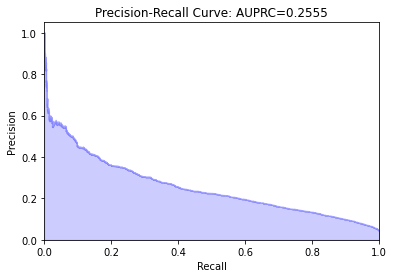

In [38]:
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)
results = ["XGBOOST-BayesSearchCV"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [39]:
opt.best_estimator_.steps

[('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                clf__colsample_bylevel=0.7837667973909442,
                clf__colsample_bynode=0.7608221730080746,
                clf__colsample_bytree=0.5506836553672291,
                clf__gamma=3.927839185126618,
                clf__learning_rate=0.030944766701643017, clf__max_depth=5,
                clf__reg_alpha=5.194141088292849,
                clf__reg_lambda=9.688551572634797,
                clf__subsample=...level=None,
                colsample_bynode=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, ...))]

In [40]:
print(opt.best_estimator_)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               clf__colsample_bylevel=0.7837667973909442,
                               clf__colsample_bynode=0.7608221730080746,
                               clf__colsample_bytree=0.5506836553672291,
                               clf__gamma=3.927839185126618,
                               clf__learning_rate=0.030944766701643017,
                               clf__max_depth=5,
                               clf__reg_alpha=5.194141088292849,
                               clf__reg_lambda=9.68855157...
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                            

<Figure size 1152x720 with 0 Axes>

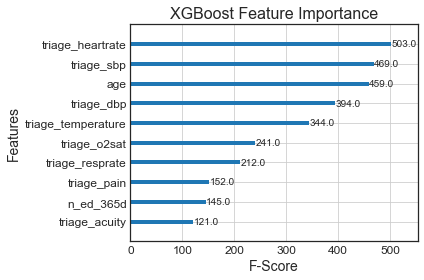

In [44]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Assuming you have 'opt' and 'best_estimator_' available from your previous code
xgboost_step = opt.best_estimator_.steps[0]
xgboost_model = xgboost_step[1]

# Set the figure size and color palette
plt.figure(figsize=(16, 10))  # Adjust the size as needed
plt.style.use('seaborn-white')  # You can change the style to your preference

# Plot the feature importances
plot_importance(xgboost_model, importance_type='weight', max_num_features=10)  # You can adjust max_num_features

# Customize the plot appearance
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('F-Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Ensure labels are not cut off

# Show the plot
plt.show()

